In [389]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.special import gamma, gammainc
import time
import warnings
warnings.filterwarnings("error")

In [156]:
# from estimator_double import NNDoubleFunctionalEstimator
from estimator_double import phi_asymptotic_nn_classification_error
from formula_double import DoubleDensityFunctionalFormulasUniform
from utility import compute_normalized_volumes, draw_truncated_gaussians, find_unit_volume

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
params = {
    'axes.labelsize': 10,
    'font.family': "serif",  # Then, "ALWAYS use sans-serif fonts"
    'font.sans-serif': "Helvetica",  # Say, "the default sans-serif font is MS Reference Sans Serif"
    'font.serif': "Palatino",  # Say, "the default sans-serif font is MS Reference Sans Serif"
    'legend.fontsize': 10,
    'lines.markersize': 5,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': True,
    'figure.figsize': [4.5, 4.5]
   }
matplotlib.rcParams.update(params)

In [5]:
markers = ['o', 's', '*', 'v', '^', 'D', 'h', 'x', '+', '8', 'p', '<', '>', 'd', 'H', 1, 2, 3, 4]

In [107]:
colormap = plt.cm.Paired  # print(matplotlib.cm.cmap_d.keys()) to check available color maps
colors = [colormap(i) for i in np.linspace(0, 1, 12)]

# NNCE

In [301]:
# Main configuration
dims = [1, 2, 3, 4, 5]
ms = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]  # sample sizes
ns = ms
num_trials = 500

In [302]:
# Compute estimates
ks = np.array([1, 2, 3, 4, 5] + [10, 15, 20])
ls = ks
alphas = np.array([])

In [394]:
distribution_type = 'gaussians'
# distribution_type = 'uniforms'

assert distribution_type in ['uniforms', 'gaussians']

if distribution_type == 'uniforms':
    # Hyperparameters for uniforms
    r = 1
    s = 2  # width for uniform distributions for Y
    sampler_double = lambda m, n, d: [r * np.random.rand(m, d), s * np.random.rand(n, d)]
    true_functional_values = DoubleDensityFunctionalFormulasUniform(a=r, b=s, dims=dims).asymptotic_nn_classification_error

if distribution_type == 'gaussians':
    # Hyperparameters for gaussians
    r = 3
    mc_estimates = np.array([0.45142747, 0.42774874, 0.42005797, 0.42110419, 0.42644394])  # gaussians (r=3)
    r = np.inf
    mc_estimates = np.array([0.4200043 , 0.35246383, 0.29670882, 0.25082934, 0.21320283])  # gaussians (r=inf)
    s = 2  # sigma for Y
    sampler_double = lambda m, n, d: [draw_truncated_gaussians(m, d, sigma=1, r=r), 
                                      draw_truncated_gaussians(n, d, sigma=s, r=r)]

    
    true_functional_values = mc_estimates

filename = 'saved_data/double_estimates_{}_nnce_a{}b{}_ntrials{}.npz'.format(
    distribution_type, r, s, str(num_trials)
)

true_functional_values = true_functional_values[np.newaxis, ...]
true_functional_values = true_functional_values[..., np.newaxis, np.newaxis]  # (num_functionals, ndims, 1, 1)
true_functional_values[..., 0, 0]

array([[0.4200043 , 0.35246383, 0.29670882, 0.25082934, 0.21320283]])

## Monte Carlo estimation

In [300]:
m = 10 ** 7
dims = np.array([1, 2, 3, 4, 5])  # np.array([1])
alpha = 1.5
r = 3 # np.inf
sigma = 2

unit_volumes = find_unit_volume(dim)

cdr = lambda alphat: (2 ** (dim / 2 - 1)) * dim * unit_volumes * \
                      gammainc(dim / 2, (r ** 2) / (2 * alphat)) * gamma(dim / 2)
p = lambda x: np.exp(- np.sum(x ** 2, axis=1) / 2) / cdr(1)
q = lambda x: np.exp(- np.sum(x ** 2, axis=1) / 2 / sigma ** 2) / cdr(sigma**2) / (sigma ** dim)


mc_estimates = np.zeros(len(dims))

for idx_dim, dim in enumerate(dims):
    x = draw_truncated_gaussians(m, dim, sigma=1, r=r)
    mc_estimates[idx_dim] = np.mean(q(x) / (p(x) + q(x)))
    print(dim, mc_estimates[idx_dim])

1 0.45141465180125867
2 0.42774982409751455
3 0.41986230479504916
4 0.4210863876376461
5 0.4265036306353476


In [358]:
filename

'saved_data/double_estimates_gaussians_nnce_ainfb2_ntrials500.npz'

## Run experiments

In [395]:
if os.path.exists(filename):
    npzfile = np.load(filename, allow_pickle=True)
    locals().update(npzfile)
    
else:
    functional_estimates = np.zeros((1, len(dims), len(ms), len(ks), num_trials));
    start_overall = time.time()
    for idim in range(len(dims)):
        for im in range(len(ms)):
            # for each dimension and each sample size
            d = dims[idim]
            m = ms[im]
            n = ns[im]
            
            start = time.time()
            for itrial in range(num_trials):
                x, y = sampler_double(m, n, d)
                u = compute_normalized_volumes(x, ks=ks)
                v = compute_normalized_volumes(x, ks=ls, y=y)
                estimates = phi_asymptotic_nn_classification_error(u, v, ks, ls)[np.newaxis, ...].mean(1)  # (1, len(ks))
                functional_estimates[:, idim, im, :, itrial] = estimates
                
            end = time.time()
            print('dim={}, m={}, n={}; {:.2f}s elapsed'.format(d, m, n, end-start))
    end_overall = time.time()
    print('Total {:.2f}s elapsed'.format(d, m, n, end_overall-start_overall))
    
    # Save functional estimates
    data = dict(ms=ms, 
                ns=ns, 
                dims=dims, 
                ks=ks, 
                ls=ls, 
                functional_estimates=functional_estimates, 
                r=r, 
                s=s, 
                distribution_type=distribution_type)
    np.savez(filename, **data);

# Compute sample means, biases, variances, and mses
sample_means = functional_estimates.mean(-1)  # mean over trials; (num_functionals, ndims, nms, nks)
sample_means[sample_means == np.inf] = 0
biases = np.abs(sample_means - true_functional_values)  # (num_functionals, ndims, nms, nks)
variances = ((functional_estimates - sample_means[..., np.newaxis])**2).mean(-1)  # (num_functionals, ndims, nms, nks)
mses = biases ** 2 + variances

dimension=1


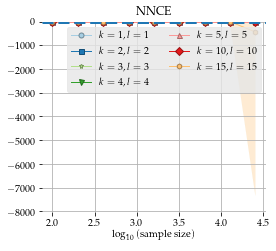

dimension=2


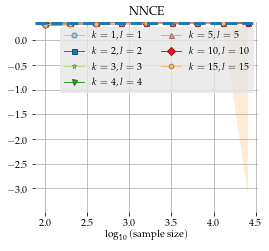

dimension=3


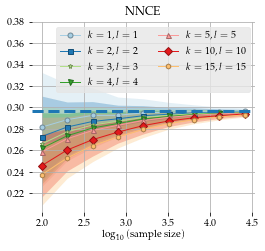

dimension=4


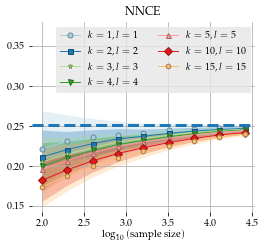

dimension=5


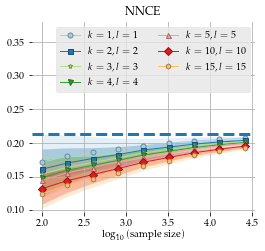

In [399]:
iftn = 0
for idim in range(len(dims)):
    print('dimension={}'.format(dims[idim]))
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    ax.grid()
    for ik in range(len(ks)):
        if 20 > ks[ik] > 0:
            ax.plot(np.log10(ms), sample_means[iftn, idim, :, ik], 
                    '{}-'.format(markers[ik]), 
                    color=colors[ik],
                    linewidth=1,
                    markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
                    label='$k={}, l={}$'.format(ks[ik], ls[ik]))
            ax.fill_between(np.log10(ms), 
                    (sample_means-np.sqrt(variances))[iftn, idim, :, ik], 
                    (sample_means+np.sqrt(variances))[iftn, idim, :, ik],
                    color=colors[ik],
                    linewidth=0.1, 
                    alpha=0.3)
    ax.axhline(true_functional_values[iftn, idim, 0, 0], linestyle='--', linewidth=3)
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
    legend = ax.legend(ncol=2, loc=1)
    frame = legend.get_frame()
    frame.set_facecolor('0.9')
    frame.set_edgecolor('0.9')

    ax.set_ylim(top=0.38)
    ax.set_xlabel(r'$\log_{10} \mathrm{(sample~size)}$')
    ax.set_title('NNCE')
    
    plt.savefig('new_figs/double_{}_r{}_d{}_convergence_{}.pdf'.format(distribution_type, r, dims[idim], 'nnce'))
    plt.show()

3-dim gaussians ($r=inf$)


<Figure size 324x324 with 0 Axes>

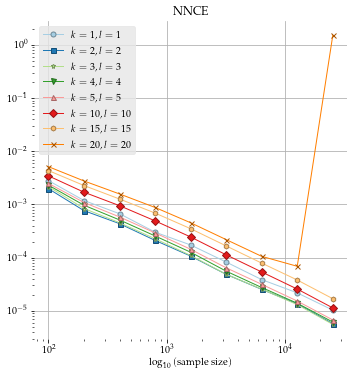

In [376]:
# Plot log(m) vs. log(MSE) for sanity check
for idim in [2]: # range(len(dims)):
    print('{}-dim {} ($r={}$)'.format(
        dims[idim],
        distribution_type,
        r,
    ))
    plt.figure(idim, clear=True)
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    fig.tight_layout(h_pad=5)
            
    iftn = 0
    ax = axs # [0][0]
    ax.grid()
    for ik in range(len(ks)):
        ax.loglog(ms, mses[iftn, idim, :, ik], 
                  '{}-'.format(markers[ik]), 
                  color=colors[ik],
                  linewidth=1,
                  markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
                  label='$k={}, l={}$'.format(ks[ik], ls[ik]))
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
    legend = ax.legend()
    frame = legend.get_frame()
    frame.set_facecolor('0.9')
    frame.set_edgecolor('0.9')
    
    ax.set_xlabel(r'$\log_{10} \mathrm{(sample~size)}$')
    ax.set_title('NNCE')
    
    plt.savefig('double_{}_r{}_d{}_mse.pdf'.format(distribution_type, r, dims[idim]))
    plt.show()

In [386]:
# Compute exponents
exponents = np.zeros((3, klnn_estimator.num_functionals, len(dims), len(ks)));  # first axis = (MSE, bias, variance)
nwarmup = 5
for iftn in range(1):
    for idim in range(len(dims)):
        x = np.log(ms[nwarmup:])[..., np.newaxis];
        y = np.stack([np.log(mses[iftn, idim, nwarmup:, :]),
                      np.log(biases[iftn, idim, nwarmup:, :]),
                      np.log(variances[iftn, idim, nwarmup:, :])], 0);

        # Perform ordinary linear regression to extract the slope
        cov = np.mean(x * y, 1) - np.mean(x) * np.mean(y, 1);
        var = np.mean((x - np.mean(x))**2);
        slope = cov / var;
        exponents[:, iftn, idim, :] = -np.squeeze(slope);

In [387]:
bias_exponents_theory = np.array([1/dim for dim in dims])
variance_exponents_theory = np.array([1 for dim in dims])
mse_exponents_theory = np.minimum(2 * bias_exponents_theory, variance_exponents_theory)
exponents_theory = np.stack([mse_exponents_theory,
                             bias_exponents_theory,
                             variance_exponents_theory], 0)

gaussians ($r=3$)


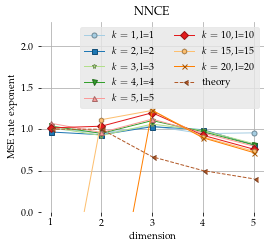

In [388]:
# for figure saving
# Plot MSE exponents
print('{} ($r={}$)'.format(distribution_type, r))

# differential entropy
fig = plt.figure(figsize=(4,3.5))
ax = fig.add_subplot(1, 1, 1)
iftn = 0
ax.grid()
for ik in range(len(ks)):
    ax.plot(dims, exponents[0, iftn, :, ik], '{}-'.format(markers[ik]),
            linewidth=1,
            label='$k={}$, l={}'.format(ks[ik], ls[ik]),
            markeredgecolor=np.minimum(np.array(colors[ik][0:3])/1.5, 1),
            color=colors[ik])
    
ax.plot(dims, exponents_theory[0, :],
        linewidth=1,
        marker=markers[-1],
        label='theory',
        linestyle='--',
        markeredgecolor=np.minimum(np.array(colors[-1][0:3])/1.5, 1),
        color=colors[-1])

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

legend = ax.legend(ncol=2, loc=1)
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.9')

ax.set_title('NNCE')
ax.set_xlabel('dimension')
ax.set_ylabel('MSE rate exponent')
ax.set_ylim(bottom=0, top=2.3)

plt.savefig('new_figs/double_{}_r{}_exponents_{}.pdf'.format(distribution_type, r, 'nnce').replace('$', '').replace('\\', '').replace(' ', '_'))
plt.show()